# The Modifiable Areal Unit Problem, visually, in Python

> [Dani Arribas-Bel](http://darribas.org) ([@darribas](http://twitter.com/darribas))

The [Modifiable Areal Unit Problem](https://en.wikipedia.org/wiki/Modifiable_areal_unit_problem) (MAUP) is a well know phenomenon for any researcher interested in spatial issues. In this notebook, we'll get our hands dirty experimenting with different geographical configurations and will see, in a practical way, some of the implications of the MAUP. In doing this, we'll also tour some of the basic functionality in [`geopandas`](http://geopandas.org). 

To motivate this exercise, let us start from the end and show how, the exact same underlying geography, can generate radically different maps, depending on how we aggregate it:

![Comparison](figs/comparison.png)

In this case, we have started from a set of points located in a hypothetical geography (left panel). We can think of them as firms located over a regional economy, the distribution of a particular species of trees over space, or any other phenomenon where the main unit of observation can be described as points located somewhere in space. Now, in the central pane, we have overlayed a five by five grid and, for every polygon, which we could think of a regions, we have counted the number of units and assigned a color based on its value. In the right pane, we have done the same, using the same underlying distribution of points, but have overlaid a ten by ten grid of polygons.

The gist of the MAUP is that, even though the original distribution is the same, the representation we access by looking at the aggregate can vary dramatically depending on the characteristics of this aggregation. In our example, the units were points and the aggregation were simple polygons in a grid. But the same problem occurs, for example, when we look at income over individuals and aggregate the average in neighborhoods, regions or countries: if the units we use for this aggregation are not meaningful, in other words, if they don't match well the underlying process, there can be substantial distortions.

Now we have the conceptual idea clear, let's see how we have arrived to the picture above! Before anything, here are the libraries you'll need to run this notebook:

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from itertools import product
from shapely.geometry import Polygon, Point

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

## Generate polygon geographies

First we need an engine that generates grids of different sides. This will allow us later to easily create many geographies with different characteristics, which will dictate the aggregation process. We can solve this problem with the following method, which generates polygons and collects them into a `GeoSeries`:

In [2]:
def gridder(nr, nc):
    '''
    Return a grid with `nr` by `nc` polygons
    ...
    
    Arguments
    ---------
    nr     : int
             Number of rows
    nc     : int
             Number of columns
    '''
    x_breaks = np.linspace(0, 1, nc+1)
    y_breaks = np.linspace(0, 1, nr+1)
    polys = []
    for x, y in product(range(nc), range(nr)):
        poly = [(x_breaks[x], y_breaks[y]), \
                (x_breaks[x], y_breaks[y+1]), \
                (x_breaks[x+1], y_breaks[y+1]), \
                (x_breaks[x+1], y_breaks[y])]
        polys.append(Polygon(poly))
    return gpd.GeoSeries(polys)

Once defined, it's easy to generate a grid of, for example, four by three polygons:

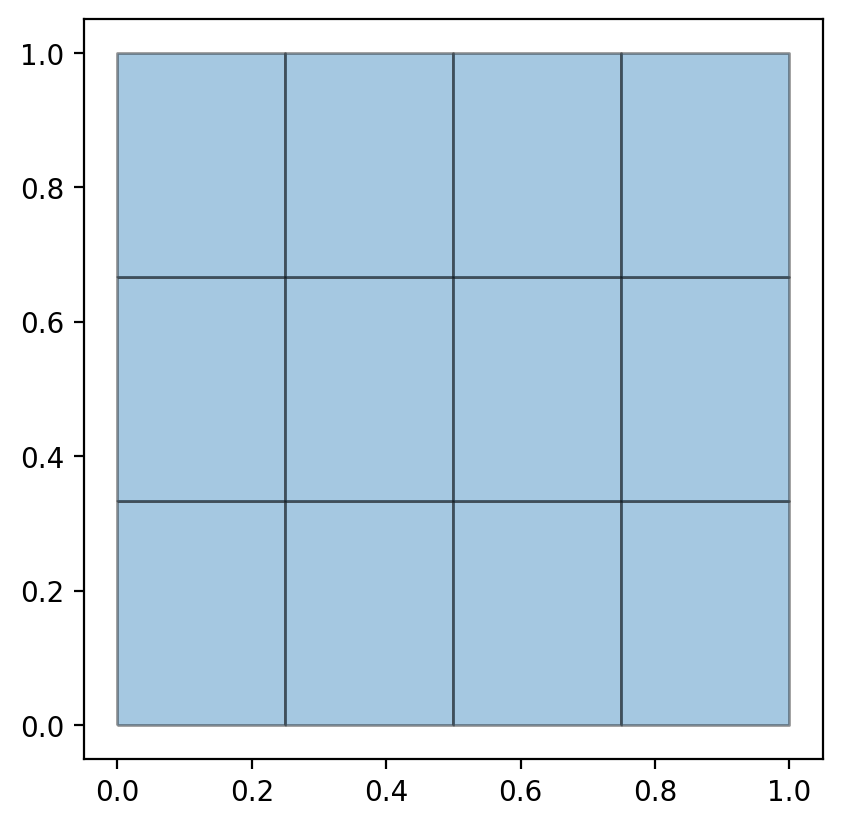

In [3]:
polys = gridder(3, 4)
polys.plot(alpha=0.4, edgecolor='black')
plt.show()

## Generate points within the geography

Now we have the "engine" to generate the geography, we need to create observations that we can pinpoint over space. The easiest way is to randomly generate points within the bounding box of the geographies we create, and store them in a different `GeoSeries`. That's exactly what the following function does:

In [4]:
def gen_pts(n):
    '''
    Generate `n` points over space and return them as a GeoSeries
    ...
    
    Arguments
    ---------
    n        : int
               Number of points to generate
    
    Return
    ------
    pts      : GeoSeries
               Series with the generated points
    '''
    xy = pd.DataFrame(np.random.random((n, 2)), columns=['X', 'Y'])
    pts = gpd.GeoSeries(xy.apply(Point, axis=1))
    return pts

This allows us to create, for example, 100 points:

In [5]:
# Set the seed to always get the same locations
np.random.seed(123)
pts = gen_pts(100)
pts.head()

0    POINT (0.69647 0.28614)
1    POINT (0.22685 0.55131)
2    POINT (0.71947 0.42311)
3    POINT (0.98076 0.68483)
4    POINT (0.48093 0.39212)
dtype: geometry

Since we already have tools to create both the underlying points *and* a geography in which to aggregate it, let us imagine what this could look like. In fact, stop imagining and simply plot them:

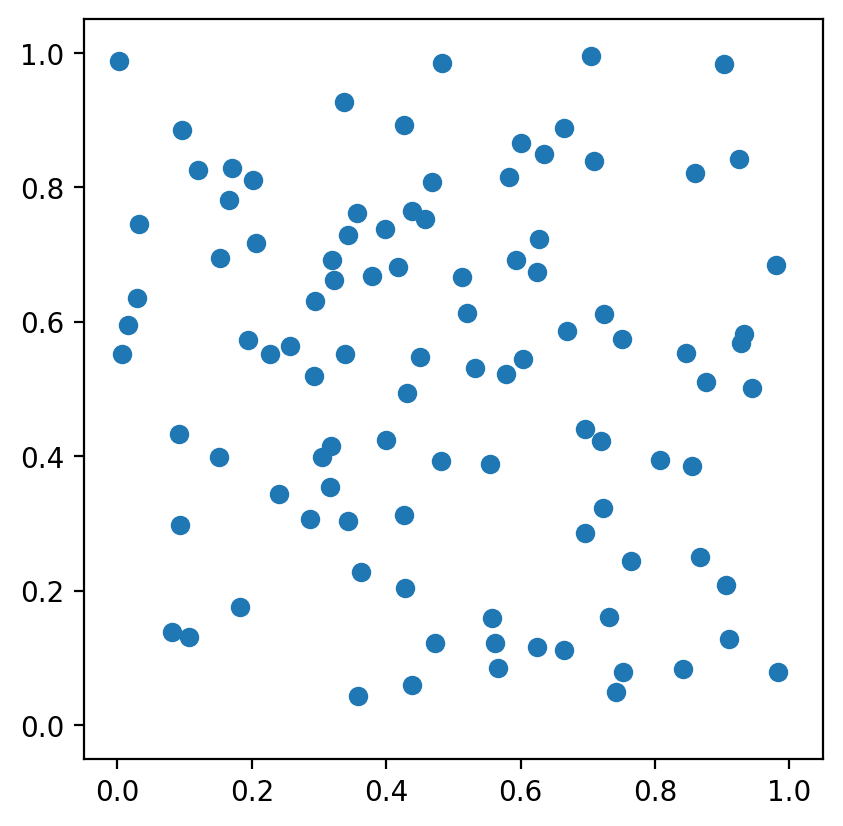

In [6]:
f, ax = plt.subplots(1)
polys.plot(alpha=0, ax=ax)
pts.plot(ax=ax)
plt.show()

## Aggregate points to polygon

Now, to get to a map like those above, we need a way to assign how many points are within each polygon. The following method does exactly that, albeit in a fairly computationally expensive way. There are faster ways to do it in `geopandas` ([spatial join](https://github.com/geopandas/geopandas/blob/master/examples/spatial_joins.ipynb), I'm looking at you), but they require additional dependencies, and are not as intuitive as this one I think. For now, this approach will have to do:

In [7]:
def map_pt2poly(pts, polys):
    '''
    Join points to the polygon where they fall into
    
    NOTE: computationally inefficient, so slow on large sizes
    ...
    
    Arguments
    ---------
    pts    : GeoSeries
             Series with the points
    polys  : GeoSeries
             Series with the polygons
    Returns
    -------
    mapa   : Series
             Indexed series where the index is the point ID and the value is 
             the polygon ID.
    '''
    mapa = []
    print(pts)
    for i, pt in pts.items():
        for j, poly in polys.items():
            if poly.contains(pt):
                mapa.append((i, j))
                pass
    mapa = np.array(mapa)
    mapa = pd.Series(mapa[:, 1], index=mapa[:, 0])
    return mapa

Check how we can collect the count for each polygon in a `GeoDataFrame` that also holds their geometries:

In [8]:
pt2poly = map_pt2poly(pts, polys)
count = pt2poly.groupby(pt2poly).size()
db = gpd.GeoDataFrame({'geometry': polys, 'count': count})
db.head()

0     POINT (0.69647 0.28614)
1     POINT (0.22685 0.55131)
2     POINT (0.71947 0.42311)
3     POINT (0.98076 0.68483)
4     POINT (0.48093 0.39212)
               ...           
95    POINT (0.20610 0.71776)
96    POINT (0.37899 0.66838)
97    POINT (0.02932 0.63590)
98    POINT (0.03220 0.74478)
99    POINT (0.47291 0.12175)
Length: 100, dtype: geometry


,geometry,count
0,"POLYGON ((0.00000 0.00000, 0.00000 0.33333, 0....",4
1,"POLYGON ((0.00000 0.33333, 0.00000 0.66667, 0....",8
2,"POLYGON ((0.00000 0.66667, 0.00000 1.00000, 0....",9
3,"POLYGON ((0.25000 0.00000, 0.25000 0.33333, 0....",8
4,"POLYGON ((0.25000 0.33333, 0.25000 0.66667, 0....",12


At this point, we have everything we need to make a map of the counts of points per polygon:

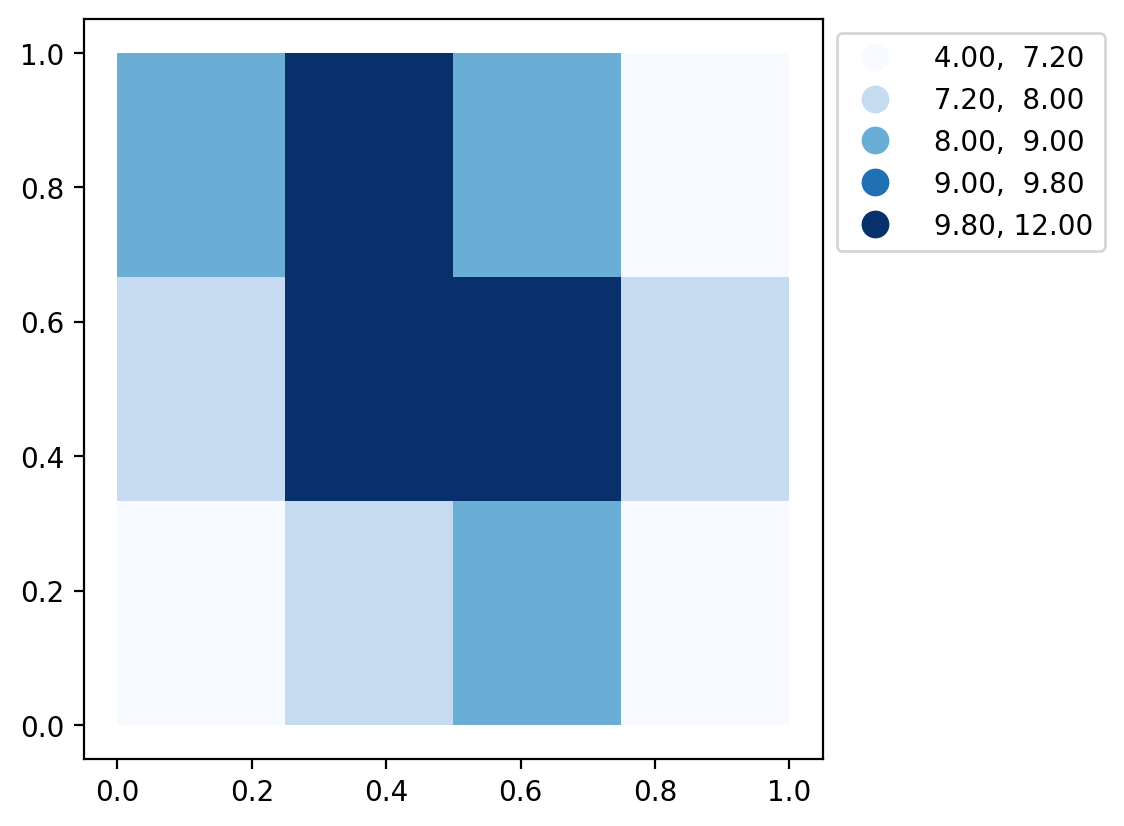

In [21]:


ax = db.plot(column='count', scheme='quantiles', legend=True, cmap='Blues')
# Set legend position
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.4, 1))

## Automated

Although we have all the pieces, one of the beauties of scripting languages like Python is that they allow you wrap different functionality so that obtaining the final outcome is easier than repeating every step every time you need the final product. In this case, we can ease the process by encapsulating the process above into a single method that takes `nr`, `nc` and the points we want to plot and generate a table of counts per polygon:

In [10]:
def count_table(nr, nc, pts):
    '''
    Create a table with counts of points in `pts` assigned to a geography of
    `nr` rows and `nc` columns
    ...
    
    Arguments
    ---------
    nr     : int
             Number of rows
    nc     : int
             Number of columns
    pts    : GeoSeries
             Series with the generated points
    
    Returns
    -------
    tab    : GeoDataFrame
             Table with the geometries of the polygons and the count of 
             points that fall into each of them
    '''
    polys = gridder(nr, nc)
    walk = map_pt2poly(pts, polys)
    count = walk.groupby(walk).size().reindex(polys.index).fillna(0)
    tab = gpd.GeoDataFrame({'geometry': polys, 'count': count})
    return tab

For example, we can generate the counts for a five by five grid:

In [11]:
counts_5x5 = count_table(5, 5, pts)
counts_5x5.head()

0     POINT (0.69647 0.28614)
1     POINT (0.22685 0.55131)
2     POINT (0.71947 0.42311)
3     POINT (0.98076 0.68483)
4     POINT (0.48093 0.39212)
               ...           
95    POINT (0.20610 0.71776)
96    POINT (0.37899 0.66838)
97    POINT (0.02932 0.63590)
98    POINT (0.03220 0.74478)
99    POINT (0.47291 0.12175)
Length: 100, dtype: geometry


,geometry,count
0,"POLYGON ((0.00000 0.00000, 0.00000 0.20000, 0....",3
1,"POLYGON ((0.00000 0.20000, 0.00000 0.40000, 0....",2
2,"POLYGON ((0.00000 0.40000, 0.00000 0.60000, 0....",4
3,"POLYGON ((0.00000 0.60000, 0.00000 0.80000, 0....",4
4,"POLYGON ((0.00000 0.80000, 0.00000 1.00000, 0....",4


And quickly plot it on quantile map using `PySAL` under the hood:

<Axes: >

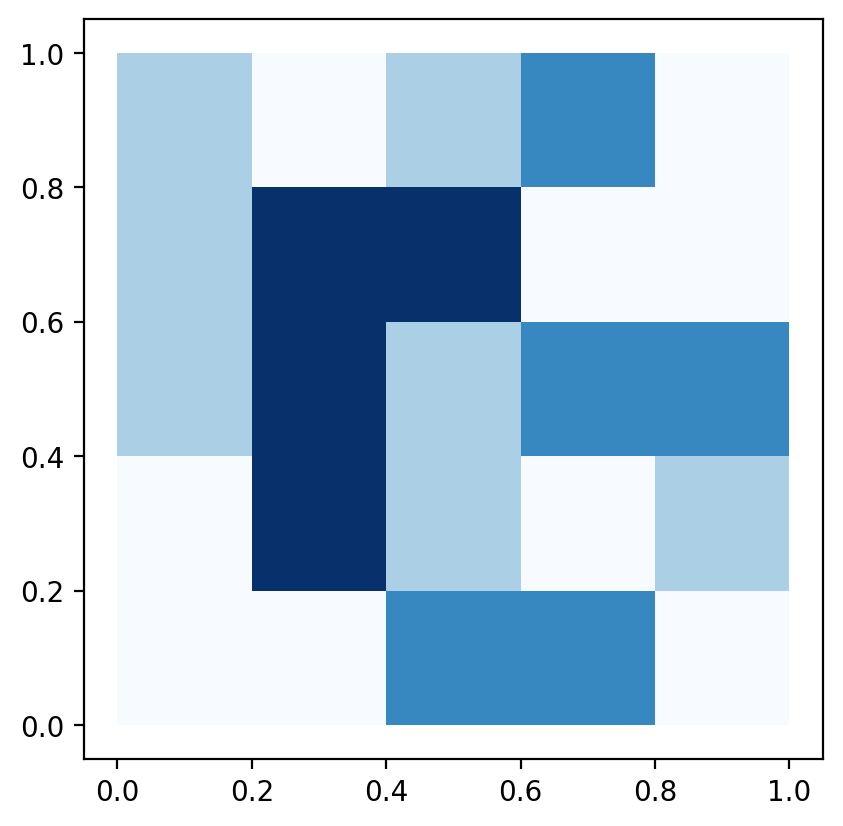

In [12]:
counts_5x5.plot(column='count', scheme='quantiles', k =4, cmap='Blues')

## Further MAUP exploration

Now we have all the pieces we require in an accessible way, let's explore what the choropleth looks like for the same set of points when we aggregate them into different geographies:

0      POINT (0.69647 0.28614)
1      POINT (0.22685 0.55131)
2      POINT (0.71947 0.42311)
3      POINT (0.98076 0.68483)
4      POINT (0.48093 0.39212)
                ...           
995    POINT (0.71558 0.79217)
996    POINT (0.82628 0.77003)
997    POINT (0.69043 0.19301)
998    POINT (0.73165 0.27471)
999    POINT (0.72182 0.09786)
Length: 1000, dtype: geometry
0      POINT (0.69647 0.28614)
1      POINT (0.22685 0.55131)
2      POINT (0.71947 0.42311)
3      POINT (0.98076 0.68483)
4      POINT (0.48093 0.39212)
                ...           
995    POINT (0.71558 0.79217)
996    POINT (0.82628 0.77003)
997    POINT (0.69043 0.19301)
998    POINT (0.73165 0.27471)
999    POINT (0.72182 0.09786)
Length: 1000, dtype: geometry


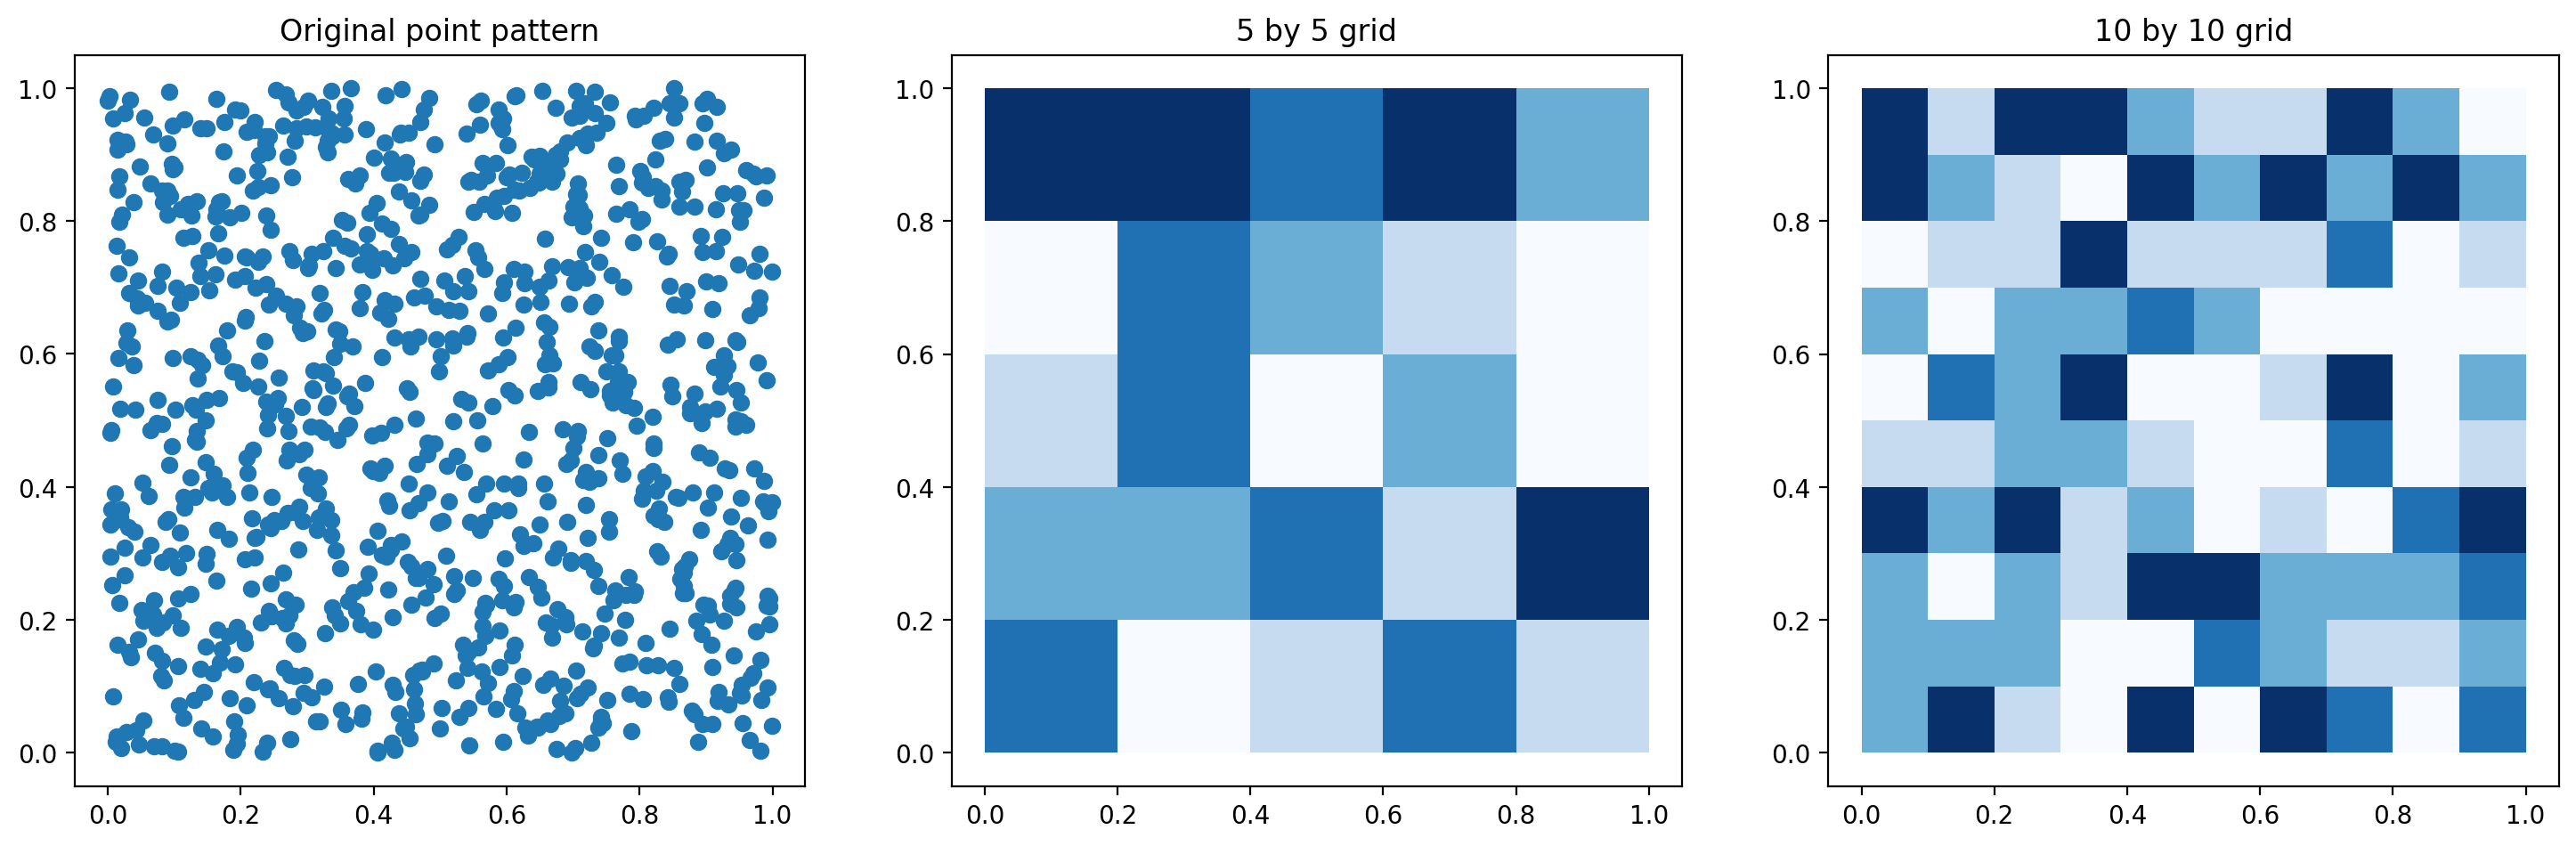

CPU times: user 2.07 s, sys: 15.3 ms, total: 2.09 s
Wall time: 983 ms


In [13]:
%%time
np.random.seed(123)
pts = gen_pts(1000)
sizes = [5, 10]
f, axs = plt.subplots(1, len(sizes)+1, figsize=(9*len(sizes), 6))
pts.plot(ax=axs[0])
axs[0].set_title('Original point pattern')
for size, ax in zip(sizes, axs[1:]):
    tab = count_table(size, size, pts)
    tab.plot(column='count', scheme='quantiles', \
             cmap='Blues', ax=ax, linewidth=0)
    ax.set_title("%i by %i grid"%(size, size))
plt.show()

We can also generate a plot for each case in which we compare the points, with the geography, with the final map:

In [14]:
def plot_case(nr, nc, pts):
    '''
    Generate an image with the original distribution, the geography, and the resulting map
    ...
    
    Arguments
    ---------
    nr     : int
             Number of rows
    nc     : int
             Number of columns
    pts    : GeoSeries
             Series with the generated points
    '''
    tab = count_table(nr, nc, pts)
    f, axs = plt.subplots(1, 3, figsize=(18, 6))
    points = pts.plot(ax=axs[0])
    points = tab.plot(alpha=0, ax=axs[1])
    
    points = tab.plot(column='count', scheme='quantiles', \
             cmap='Blues', ax=axs[2], linewidth=0)
    plt.show()    

0      POINT (0.69647 0.28614)
1      POINT (0.22685 0.55131)
2      POINT (0.71947 0.42311)
3      POINT (0.98076 0.68483)
4      POINT (0.48093 0.39212)
                ...           
995    POINT (0.71558 0.79217)
996    POINT (0.82628 0.77003)
997    POINT (0.69043 0.19301)
998    POINT (0.73165 0.27471)
999    POINT (0.72182 0.09786)
Length: 1000, dtype: geometry


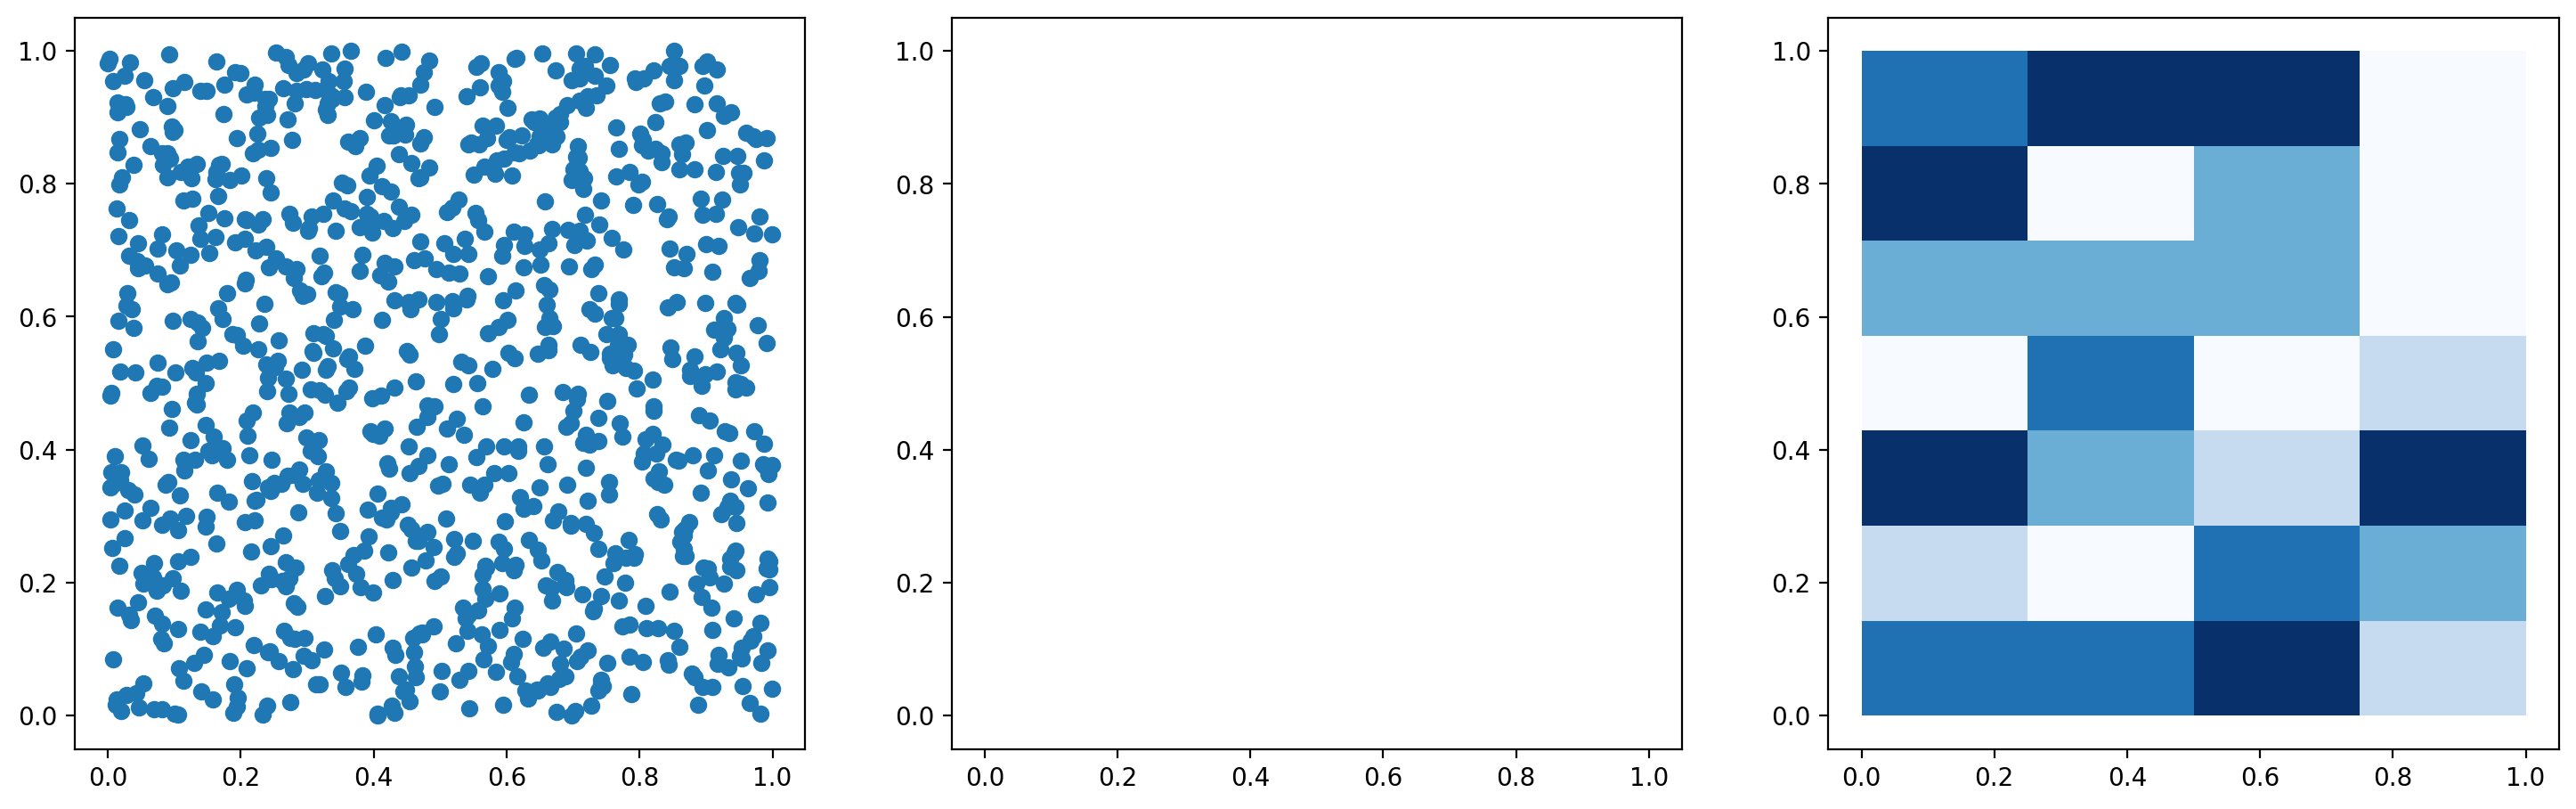

In [15]:
plot_case(7, 4, pts)

And then run if for several cases:

0      POINT (0.69647 0.28614)
1      POINT (0.22685 0.55131)
2      POINT (0.71947 0.42311)
3      POINT (0.98076 0.68483)
4      POINT (0.48093 0.39212)
                ...           
495    POINT (0.46336 0.05839)
496    POINT (0.53866 0.14604)
497    POINT (0.63408 0.26440)
498    POINT (0.69092 0.34715)
499    POINT (0.00417 0.29489)
Length: 500, dtype: geometry


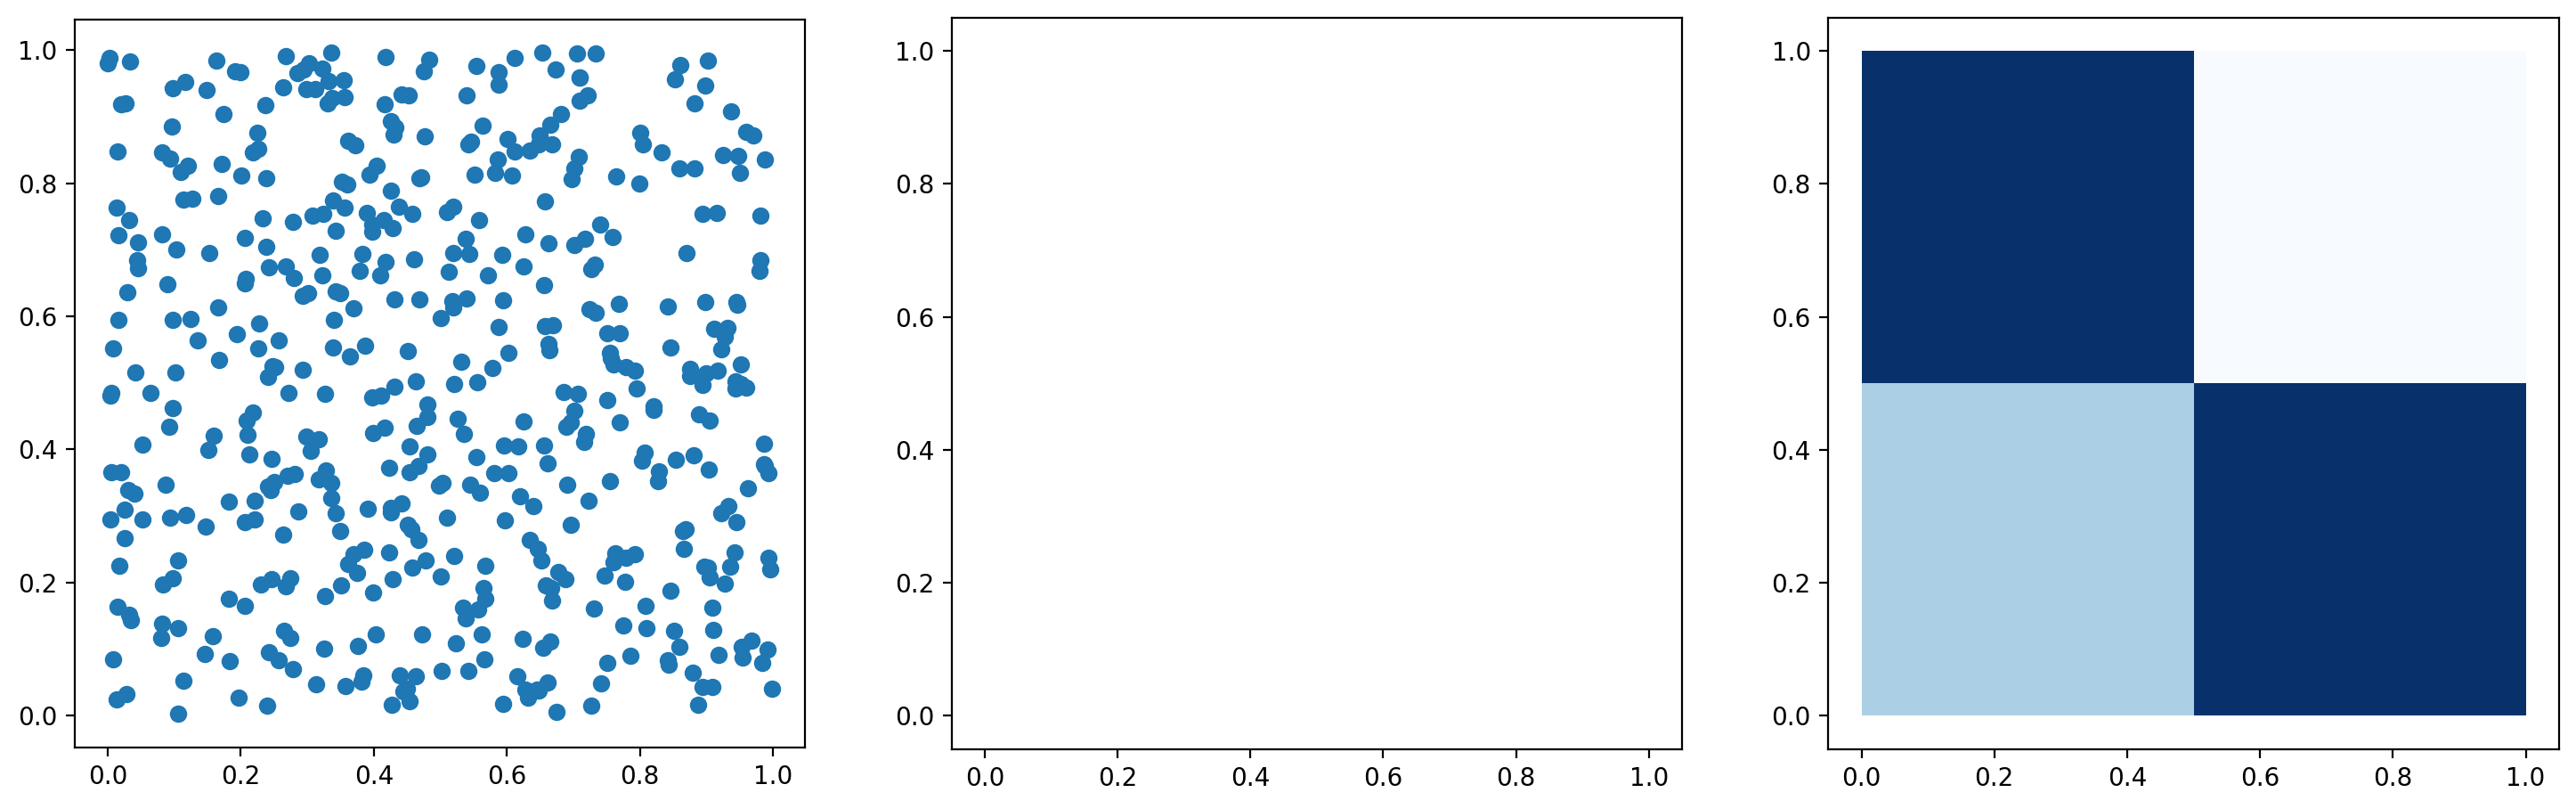

0      POINT (0.69647 0.28614)
1      POINT (0.22685 0.55131)
2      POINT (0.71947 0.42311)
3      POINT (0.98076 0.68483)
4      POINT (0.48093 0.39212)
                ...           
495    POINT (0.46336 0.05839)
496    POINT (0.53866 0.14604)
497    POINT (0.63408 0.26440)
498    POINT (0.69092 0.34715)
499    POINT (0.00417 0.29489)
Length: 500, dtype: geometry


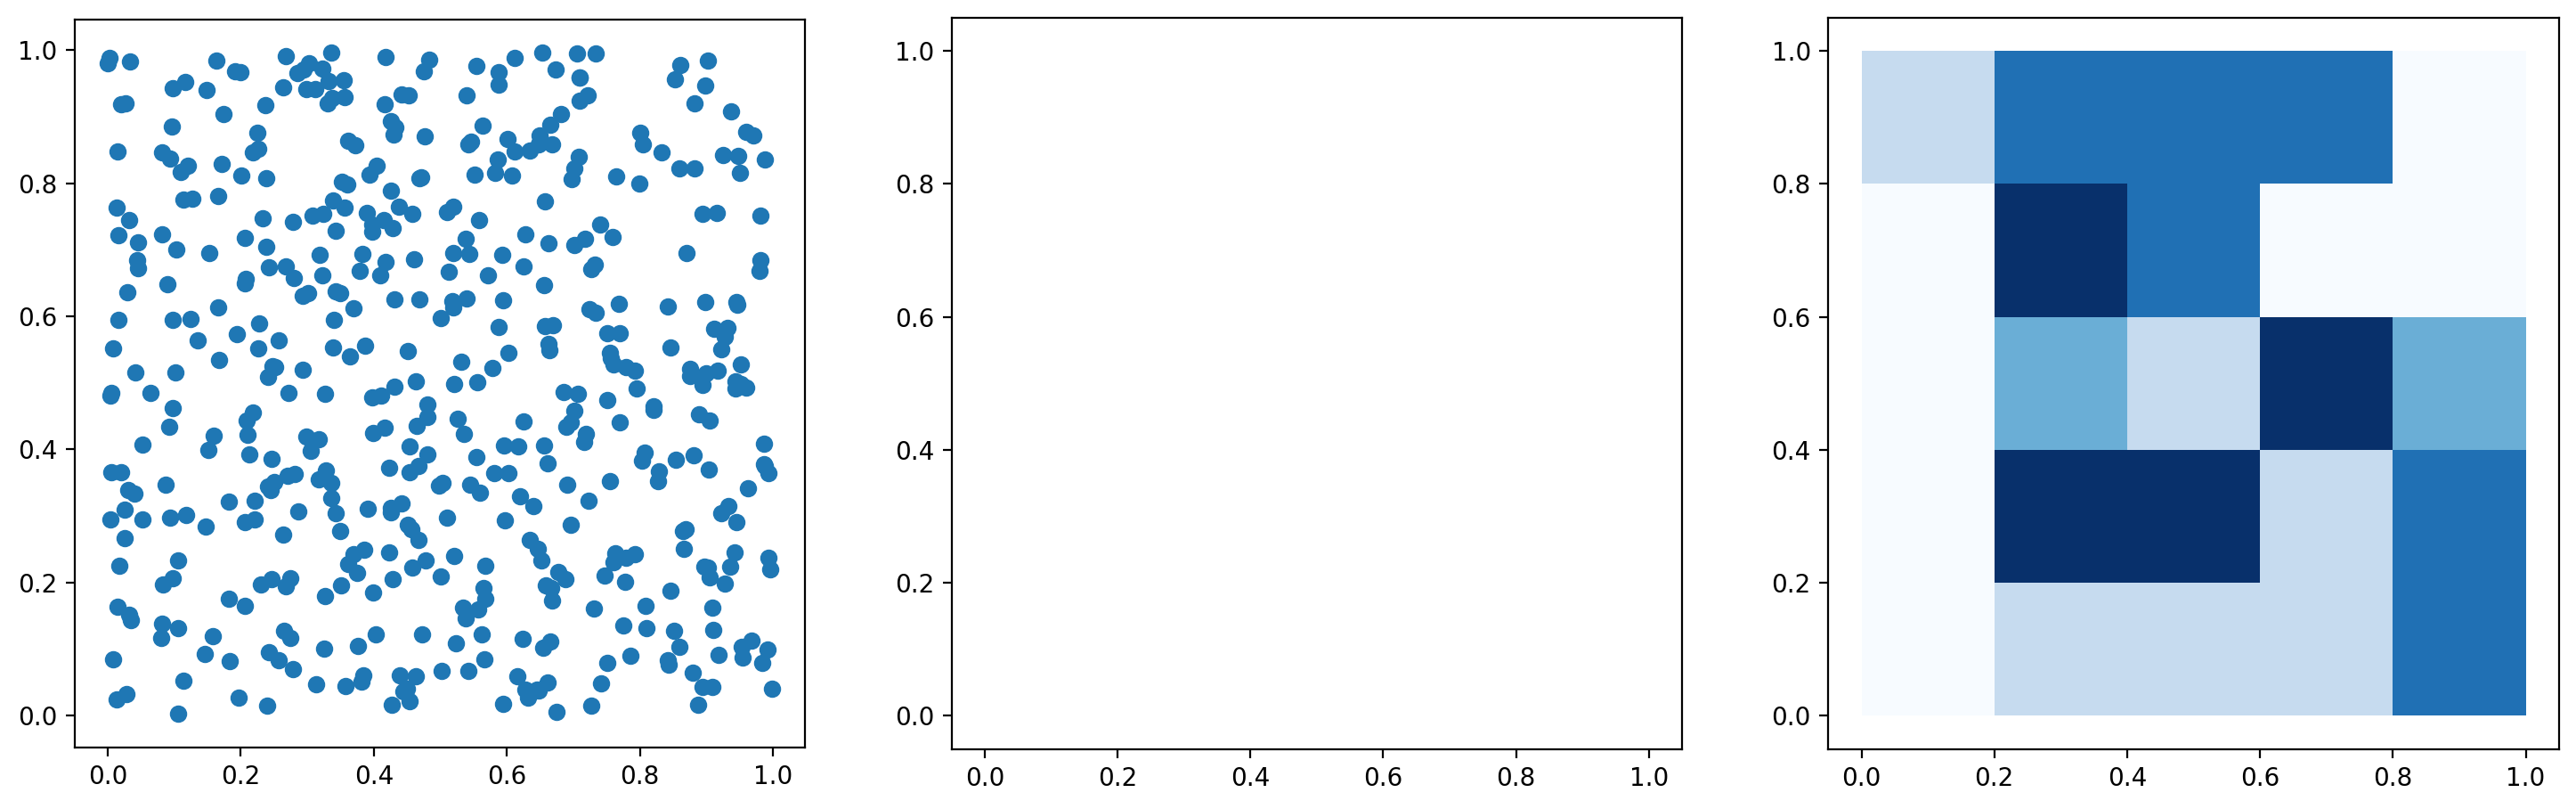

0      POINT (0.69647 0.28614)
1      POINT (0.22685 0.55131)
2      POINT (0.71947 0.42311)
3      POINT (0.98076 0.68483)
4      POINT (0.48093 0.39212)
                ...           
495    POINT (0.46336 0.05839)
496    POINT (0.53866 0.14604)
497    POINT (0.63408 0.26440)
498    POINT (0.69092 0.34715)
499    POINT (0.00417 0.29489)
Length: 500, dtype: geometry


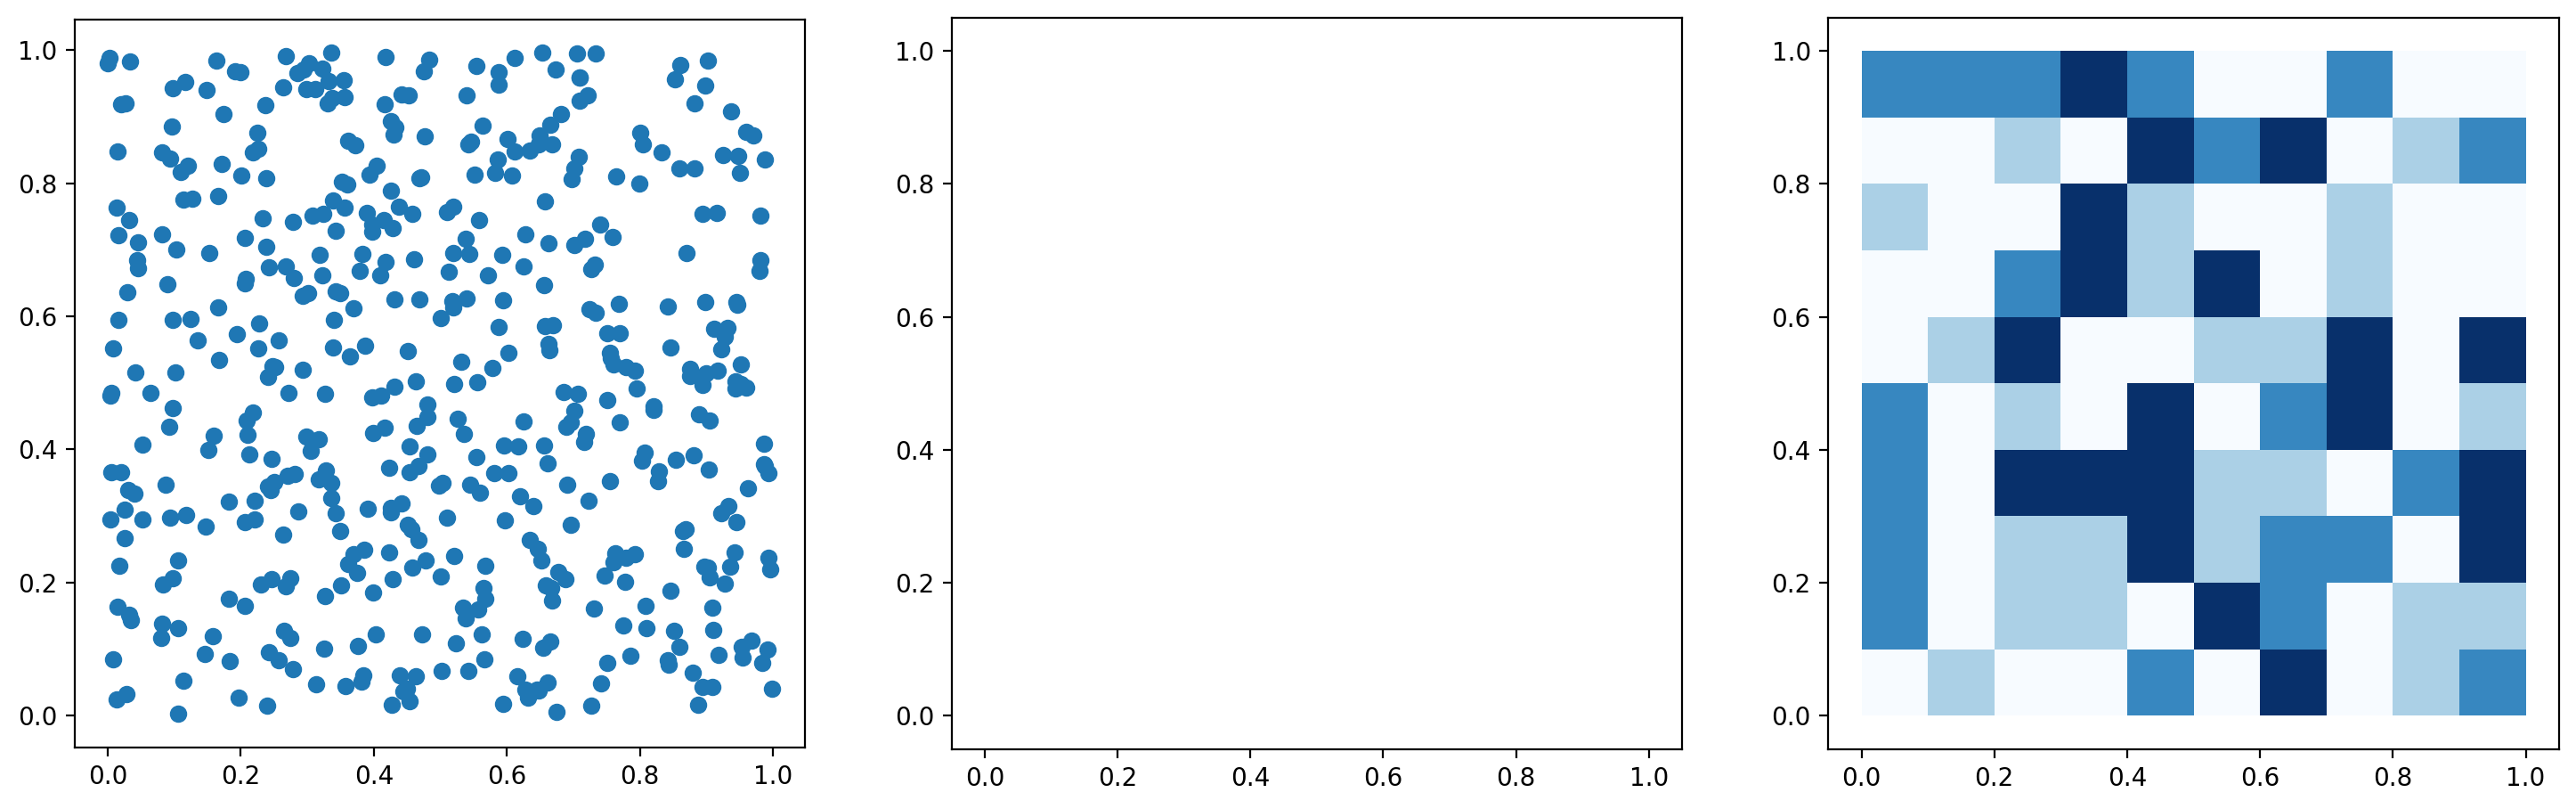

In [16]:
np.random.seed(123)
pts = gen_pts(500)
plot_case(2, 2, pts)
plot_case(5, 5, pts)
plot_case(10, 10, pts)

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Modifiable Areal Unit Problem, visually, in Python</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://darribas.org" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

